Detections Database and API
=======================

This notebook demonstrates how to access the HDF5 container for the HETDEX line detections database. This database is a catalog of line emission detections and their associated 1D, aperture summed, psf-weighted spectra. There are three tables contained within this HDF5 file: 

1. Detections - this is the main database of line detection sources. It provides the position and central wavelength of each detection and corresponding line fluxes. A source detection corresponds to an emission line so it is possible to have multiple line detections at different wavelengths for a single source. There can also be multiple observations of the same line if it has been observed in multiple shots or if it is associated with a large source. 


2. Fibers - for each source detection, this table lists information about each fiber used to extract the flux measurment and weighted spectrum. This allows a user to return to the processed data products (ie. the shot HDF5 files) to investigate the source further. 


3. Spectra - for each source, this table contains arrays of wavelength and 1D flux-weighted aperture summed spectral data and corresponding errors. Non-calibrated spectra is also provided in counts


4. Elixer - a direct row matching of Elixer classification info for each row in the Detections table. The hetdex gmag value is also found in this table. For full Elixer data including catalog and aperture P(LAE)/P(OII) values please see the detects/elixer.h5 file for a specific release. These are the ones currently accessible in the API and the curated catalogs:

    "plae_sdss_g" = P(LAE)/P(OII) from g-mag with HETDEX 1 D spectrum limits in plae_sdss_g_max/min
    
    "combined_plae"  = ELiXer weighted combination of the multiple PLAE/POII with error in combine_plae_err
    
    "plae_classification" = ELiXer probability that the line is LyA (0.0 - 1.0) [WARNING! Very experimental!!] 



In [1]:
%matplotlib inline

import numpy as np
import tables as tb
import matplotlib.pyplot as plt

from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
import astropy.units as u

from hetdex_api.config import HDRconfig
from hetdex_api.detections import Detections
from hetdex_api.elixer_widget_cls import ElixerWidget

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Use the latest curated catalog: 

In [3]:
detects = Detections( curated_version='2.1.1')

In [4]:
# this is a suggested query to find LAEs:
sel_lae = (detects.sn > 5.5) * (detects.plae_classification > 0.75) * (np.logical_not(detects.gmag<20))

In [5]:
#spectra can be accessed using get_spectrum()

spec = detects.get_spectrum(2100191119)

In [6]:
spec

wave1d,spec1d,spec1d_err
Angstrom,1e-17 erg / (Angstrom cm2 s),1e-17 erg / (Angstrom cm2 s)
float32,float32,float32
3470.0,-0.016949153,9.75
3472.0,-0.016949153,9.75
3474.0,-0.016949153,9.75
3476.0,-0.016949153,9.75
3478.0,-0.016949153,9.75
3480.0,-0.016949153,9.75
3482.0,-0.016949153,9.75
3484.0,0.875,9.254767


### Explore Using ElixerWidget:

In [7]:
elix_widget = ElixerWidget(detectlist = detects.detectid[sel_lae])

interactive(children=(BoundedIntText(value=2100000000, description='DetectID:', max=10000000000, min=100000000…

### Initiate the API and Access the full database

When you call `Detections()` you intiate the Detections Class object which takes columns from the Detections Table in the HDF5 file and adds them as array attributes to the Detections class object. It also converts ra/dec into astropy skycoords in the `coords` attribute, calculates an approximate gband magnitude using the 1D spectra and adds elixer probabilities for each detection. If you append the call with `refine()` then a number of downselections are applied to the database to return a more robust list of line emitters. `refine()` removes spurious detections found in bad amps or at the edges of the CCD or in shots that are not deemed appropriate for HETDEX analysis. It can also remove all bright objects above a specific gband magnitude if desired (default to None if no option is given).

In [8]:
# To access the latest HDRX.X lines database (ie. the full H5 file):

detects = Detections()

# to remove the latest bad amps and pixels (this isn't needed if you are using a curated catalog)

# detects = Detections(survey='hdr2.1', catalog_type='lines').refine()

# or if you want to open the continuum source catalog:
# detects = Detections(survey='hdr2.1', catalog_type='continuum')

### Note if you do not want to load the whole table, but just access spectra for a specific detectid:

In [9]:
det_object = Detections('hdr2.1', loadtable=False)

In [10]:
spec = det_object.get_spectrum(2100191119)

In [11]:
spec

wave1d,spec1d,spec1d_err
Angstrom,1e-17 erg / (Angstrom cm2 s),1e-17 erg / (Angstrom cm2 s)
float32,float32,float32
3470.0,-0.016949153,9.75
3472.0,-0.016949153,9.75
3474.0,-0.016949153,9.75
3476.0,-0.016949153,9.75
3478.0,-0.016949153,9.75
3480.0,-0.016949153,9.75
3482.0,-0.016949153,9.75
3484.0,0.875,9.254767


Here are a list of attributes built into the Detections class:

In [12]:
detects.__dict__.keys()

dict_keys(['version', 'survey', 'loadtable', 'filename', 'hdfile', 'detectid', 'shotid', 'ra', 'dec', 'date', 'obsid', 'wave', 'wave_err', 'flux', 'flux_err', 'linewidth', 'linewidth_err', 'continuum', 'continuum_err', 'sn', 'sn_err', 'chi2', 'chi2_err', 'multiframe', 'fibnum', 'x_raw', 'y_raw', 'amp', 'chi2fib', 'detectname', 'expnum', 'fiber_id', 'ifuid', 'ifuslot', 'inputid', 'noise_ratio', 'specid', 'weight', 'x_ifu', 'y_ifu', 'combined_continuum', 'combined_continuum_err', 'combined_plae', 'combined_plae_err', 'mag_sdss_g', 'mag_sdss_g_err', 'plae_classification', 'plae_sdss_g', 'plae_sdss_g_max', 'plae_sdss_g_min', 'gmag', 'gmag_err', 'field', 'fwhm', 'fluxlimit_4540', 'throughput', 'n_ifu', 'vis_class', 'coords'])

If you prefer working in astropy tables, you can grab it this way:

In [13]:
detect_table = detects.return_astropy_table()

In [14]:
detect_table

detectid,fwhm,throughput,fluxlimit_4540,shotid,field,n_ifu,gmag_err,gmag,ra,dec,date,obsid,wave,wave_err,flux,flux_err,linewidth,linewidth_err,continuum,continuum_err,sn,sn_err,chi2,chi2_err,multiframe,fibnum,x_raw,y_raw,amp,chi2fib,detectname,expnum,fiber_id,ifuid,ifuslot,inputid,noise_ratio,specid,weight,x_ifu,y_ifu,combined_continuum,combined_continuum_err,combined_plae,combined_plae_err,mag_sdss_g,mag_sdss_g_err,plae_classification,plae_sdss_g,plae_sdss_g_max,plae_sdss_g_min
int64,float64,float64,float64,int64,str12,int64,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str20,int32,int32,int32,str2,float32,str40,int32,str38,str3,str3,str40,float32,str3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2100000000,2.3224666118621826,0.09000000357627869,1.5849100855000002e-16,20170103002,cosmos,14,24.098675,24.098675,149.79932,1.986114,20170103,2,4345.88,0.6,29.26,4.31,3.54,0.57,-0.07,0.21,5.66,0.86,1.18,0.22,multi_004_106_033_RU,79,428,730,RU,1.9690311,HETDEX J095911.84+015910.0,2,20170103002_2_multi_004_106_033_RU_079,033,106,20170103v002_004_106_033_001,1.28,004,0.184,22.88,15.42,1.2131073e-18,2.0484033e-19,1000.0,0.0,24.098675,0.26964894,0.78626347,1000.0,1000.0,1000.0
2100000001,2.3224666118621826,0.09000000357627869,1.5849100855000002e-16,20170103002,cosmos,14,23.643944,23.643944,149.80261,1.991804,20170103,2,4320.58,0.82,27.36,5.19,3.99,0.91,-0.04,0.23,4.91,0.76,1.27,0.23,multi_004_106_033_RU,69,416,635,RU,0.93445796,HETDEX J095912.63+015930.5,2,20170103002_2_multi_004_106_033_RU_069,033,106,20170103v002_004_106_033_003,1.1,004,0.1825,-1.27,17.63,4.9205133e-19,2.287573e-19,1000.0,0.0,23.643944,0.17493318,0.999001,1000.0,1000.0,1000.0
2100000003,2.3224666118621826,0.09000000357627869,1.5849100855000002e-16,20170103002,cosmos,14,24.912663,24.912663,149.80013,1.987484,20170103,2,4158.08,0.83,17.89,4.79,2.58,0.9,-0.38,0.27,4.64,0.86,1.15,0.24,multi_004_106_033_RU,81,335,747,RU,2.114908,HETDEX J095912.03+015914.9,1,20170103002_1_multi_004_106_033_RU_081,033,106,20170103v002_004_106_033_008,0.91,004,0.184,17.8,15.42,1.05312435e-19,2.5742517e-19,1000.0,0.0,24.912663,0.55649275,0.999001,1000.0,1000.0,1000.0
2100000004,2.3224666118621826,0.09000000357627869,1.5849100855000002e-16,20170103002,cosmos,14,24.49108,24.49108,149.80464,1.995217,20170103,2,4322.88,1.0,30.14,5.63,5.47,1.23,-0.05,0.2,4.74,0.98,1.15,0.22,multi_004_106_033_RU,74,417,678,RU,1.6961228,HETDEX J095913.11+015942.8,1,20170103002_1_multi_004_106_033_RU_074,033,106,20170103v002_004_106_033_010,1.3,004,0.198,-13.98,17.63,1.3361595e-18,1.7093001e-19,1000.0,0.0,24.49108,0.48794377,0.88179207,1000.0,1000.0,1000.0
2100000009,2.3224666118621826,0.09000000357627869,1.5849100855000002e-16,20170103002,cosmos,14,18.140495,18.140495,149.78693,1.907993,20170103,2,3664.07,1.07,91.23,17.86,5.73,1.3,16.89,0.61,7.62,0.86,1.29,0.23,multi_008_093_054_LL,26,91,242,LL,1.5422429,HETDEX J095908.86+015428.8,1,20170103002_1_multi_008_093_054_LL_026,054,093,20170103v002_008_093_054_007,0.87,008,0.1653,-15.25,-2.2,2.7033165e-16,1.9626645e-16,1000.0,0.0,18.140495,0.0018189953,0.65575963,1000.0,1000.0,1000.0
2100000011,2.3224666118621826,0.09000000357627869,1.5849100855000002e-16,20170103002,cosmos,14,19.428492,19.428492,149.78745,1.908307,20170103,2,5244.96,2.81,48.44,18.62,9.0,3.55,14.73,0.52,8.13,1.1,3.32,0.23,multi_008_093_054_LL,47,887,437,LL,1.4970931,HETDEX J095908.99+015429.9,3,20170103002_3_multi_008_093_054_LL_047,054,093,20170103v002_008_093_054_009,0.57,008,0.2016,-19.07,-4.41,8.256695e-17,9.6145764e-17,0.001,0.0,19.428492,0.004161307,0.19377284,0.001,0.001,0.001
2100000014,2.3224666118621826,0.09000000357627869,1.5849100855000002e-16,20170103002,cosmos,14,19.117628,19.117628,149.78627,1.908183,20170103,2,4351.53,2.31,311.92,126.16,24.22,6.23,11.91,2.14,24.06,5.45,2.57,0.22,multi_008_093_054_LL,7,437,79,LL,1.5975373,HETDEX J095908.70+015

## How we made the subset catalog for the team:

In [15]:
sel_field = (detects.field == 'cosmos') | (detects.field == 'dex-fall') | (detects.field == 'dex-spring') | (detects.field == 'egs') | (detects.field == 'goods-n')
sel_chi2 = detects.chi2 < 1.2
sel_wave = ( detects.wave >= 3510 ) * (detects.wave <= 5490)
sel_lw = (detects.linewidth <= 6)
sel_cont = detects.continuum > -3
sel_sn = detects.sn >= 4.8
sel_chi2fib = (detects.chi2fib < 4.5)

sel_cat = sel_field * sel_chi2 * sel_wave * sel_lw * sel_cont * sel_sn * sel_chi2fib

det_table = detects.return_astropy_table()

In [16]:
team_table = detect_table[sel_cat]

## Querying by sky coordinates

Upon initialization of the Detections Class, sky coordinates are converted to an Astropy sky coordinates array to allow for easy querying:

In [17]:
detects.coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(149.79932 , 1.986114), (149.80261 , 1.991804),
     (149.80013 , 1.987484), ..., ( 36.488354, 0.404577),
     ( 36.49977 , 0.405466), ( 36.496384, 0.411001)]>

To query a region of the sky, you can use the Detections function `query_by_coords` which takes an astropy coords objects as an argument as well as a radius represented by an astropy quantity. It returns a boolean mask to index the Detections class object.

In [18]:
obj_coords = SkyCoord(199.35704 * u.deg, 51.06718 * u.deg, frame='icrs')

In [19]:
maskregion = detects.query_by_coords(obj_coords, 10. * u.arcsec)

The Detections class allows slicing so that a boolean mask applied to the class will slice each array attribute accordingly:

In [20]:
detects_in_region = detects[maskregion]
print(np.size(detects_in_region.detectid))

6


## Find a direct line match

If you want to find an exact line match you can use the function `find_match()`

In [21]:
obj_coords = SkyCoord(199.35704 * u.deg, 51.06718 * u.deg, frame='icrs')

In [22]:
wave_obj = 3836.

In [23]:
idx = detects.find_match(obj_coords, wave=wave_obj, radius=5.*u.arcsec, dwave=5 )

In [24]:
detects.detectid[idx]

array([2100191119])

In [25]:
detect_table[idx]

detectid,fwhm,throughput,fluxlimit_4540,shotid,field,n_ifu,gmag_err,gmag,ra,dec,date,obsid,wave,wave_err,flux,flux_err,linewidth,linewidth_err,continuum,continuum_err,sn,sn_err,chi2,chi2_err,multiframe,fibnum,x_raw,y_raw,amp,chi2fib,detectname,expnum,fiber_id,ifuid,ifuslot,inputid,noise_ratio,specid,weight,x_ifu,y_ifu,combined_continuum,combined_continuum_err,combined_plae,combined_plae_err,mag_sdss_g,mag_sdss_g_err,plae_classification,plae_sdss_g,plae_sdss_g_max,plae_sdss_g_min
int64,float64,float64,float64,int64,str12,int64,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str20,int32,int32,int32,str2,float32,str40,int32,str38,str3,str3,str40,float32,str3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2100191119,1.4780957698822021,0.15860000252723694,7.054422355000001e-17,20180313011,dex-spring,29,24.453909,24.453909,199.35716,51.067116,20180313,11,3836.54,0.45,43.68,4.07,4.05,0.48,0.4,0.17,7.29,0.86,1.09,0.22,multi_025_076_032_RU,32,178,300,RU,1.3960594,HETDEX J131725.72+510401.6,1,20180313011_1_multi_025_076_032_RU_032,032,076,20180313v011_025_076_032_008,1.65,025,0.3106,-6.36,22.03,1.4228122e-18,5.3054424e-19,1000.0,0.0,24.453909,0.1621258,0.95363724,1000.0,1000.0,1000.0


## Check out matched sources in the ElixerWidget

For this example, we have found 12 detections in this region, we can examine these via the ELiXer reports using the `ElixerWidget()` class from `hetdex_api.elixer_widget_cls.py`. To do so we need to save the detectid list to examine in the widget.

In [26]:
np.savetxt('detects_obj.txt', detects_in_region.detectid)

You can the run the elixer_widget to scan through the ELiXer reports for this object. Use the "Next DetectID" button to scan the list. The "DetectID" text widget will give access to all reports interactively and scans in increasing single digit increments, but the green Next DetectID button will go in order of the ingest list from 'detects_obj.txt'.

In [27]:
elix_widget = ElixerWidget(detectlist = detects_in_region.detectid)
#elix_widget = ElixerWidget(detectfile='detects_obj.txt')

interactive(children=(BoundedIntText(value=2100191119, description='DetectID:', max=10000000000, min=100000000…

For more information on using the Elixer Widgets GUI go to Notebook 12. We will discuss team classification efforts there. But for quick investigation its helpful to pull the GUI up to just scan through a detection list.

## Accessing 1D Spectra

Spectra in counts and flux-calibrated units are stored in the Spectra Table of the Detection HDF5 file, it can be accessed directly through the Detections class object which stores the detect HDF5 as an attribute:

In [28]:
print(detects.hdfile)

/scratch/03946/hetdex/hdr2.1/detect/detect_hdr2.1.h5 (File) ''
Last modif.: 'Thu Aug 13 11:38:47 2020'
Object Tree: 
/ (RootGroup) ''
/Detections (Table(1482880,)) 'HETDEX Line Detection Catalog'
/Elixer (Table(1482880,)) 'Elixer Info'
/Fibers (Table(28328155,)) 'Fiber info for each detection'
/Spectra (Table(1482880,)) '1D Spectra for each Line Detection'



In [29]:
spectra = detects.hdfile.root.Spectra

This is a very large table so its not advised to read it in all at once. The columns are:

In [30]:
spectra.cols

/Spectra.cols (Cols), 12 columns
  detectid (Column(1482880,), int64)
  wave1d (Column(1482880, 1036), ('<f4', (1036,)))
  spec1d (Column(1482880, 1036), ('<f4', (1036,)))
  spec1d_err (Column(1482880, 1036), ('<f4', (1036,)))
  counts1d (Column(1482880, 1036), ('<f4', (1036,)))
  counts1d_err (Column(1482880, 1036), ('<f4', (1036,)))
  apsum_counts (Column(1482880, 1036), ('<f4', (1036,)))
  apsum_counts_err (Column(1482880, 1036), ('<f4', (1036,)))
  apcor (Column(1482880, 1036), ('<f4', (1036,)))
  flag_pix (Column(1482880, 1036), ('<f4', (1036,)))
  spec1d_nc (Column(1482880, 1036), ('<f4', (1036,)))
  spec1d_nc_err (Column(1482880, 1036), ('<f4', (1036,)))

Flux calibrated, psf-weighted 1D spectra can be retrieved via the API for a single detectid through the function `get_spectrum`:

In [32]:
detectid_nice_lae = 2100744791
spec_table = detects.get_spectrum(detectid_nice_lae) 

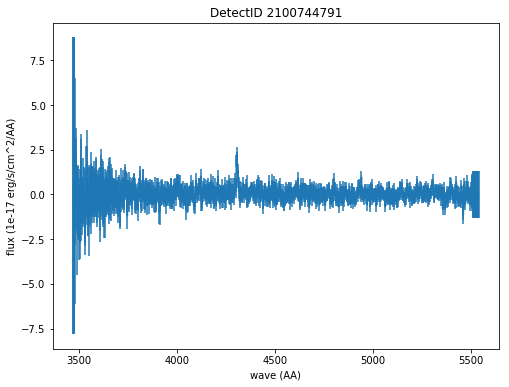

In [33]:
detects.plot_spectrum(detectid_nice_lae)

or if we want to zoom in on the emission line:

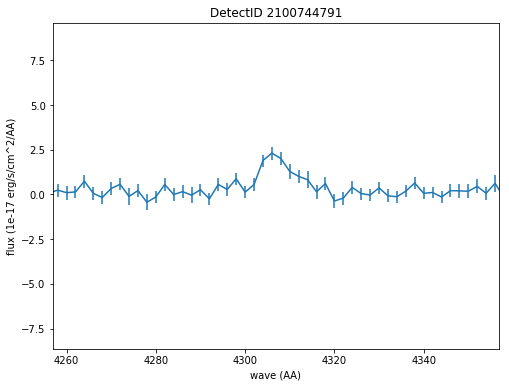

In [34]:
cw = detects.wave[detects.detectid == detectid_nice_lae]
detects.plot_spectrum(detectid_nice_lae, xlim=(cw-50, cw+50))

You can also save the spectrum to a text file. It is automatically saved as spec_##detectid##.dat, but you can also use the argument `outfile`

In [35]:
detects.save_spectrum(detectid_nice_lae)
# or
# detects.save_spectrum(detectid_nice_lae, outfile='tmp.txt')

## Getting Fiber information for a detection

You can find a list of all fibers used in the measurement in the Fibers table. The Fibers table and its associated columns can be accessed similar to the Spectra table by searching for a match in the the detectid column. 

In [38]:
fibers = detects.hdfile.root.Fibers
fibers.cols

/Fibers.cols (Cols), 23 columns
  detectid (Column(28328155,), int64)
  ra (Column(28328155,), float32)
  dec (Column(28328155,), float32)
  multiframe (Column(28328155,), |S20)
  fiber_id (Column(28328155,), |S38)
  x_ifu (Column(28328155,), float32)
  y_ifu (Column(28328155,), float32)
  date (Column(28328155,), int32)
  obsid (Column(28328155,), int32)
  expnum (Column(28328155,), int32)
  distance (Column(28328155,), float32)
  timestamp (Column(28328155,), |S17)
  wavein (Column(28328155,), float32)
  flag (Column(28328155,), int32)
  weight (Column(28328155,), float32)
  ADC (Column(28328155, 5), ('<f4', (5,)))
  amp (Column(28328155,), |S2)
  fibnum (Column(28328155,), int32)
  ifuid (Column(28328155,), |S3)
  ifuslot (Column(28328155,), |S3)
  specid (Column(28328155,), |S3)
  x_raw (Column(28328155,), int32)
  y_raw (Column(28328155,), int32)

Access the fiber table for the above source:

In [39]:
fiber_table = fibers.read_where("detectid == detectid_nice_lae") 

In [40]:
Table(fiber_table)

detectid,ra,dec,multiframe,fiber_id,x_ifu,y_ifu,date,obsid,expnum,distance,timestamp,wavein,flag,weight,ADC [5],amp,fibnum,ifuid,ifuslot,specid,x_raw,y_raw
int64,float32,float32,bytes20,bytes38,float32,float32,int32,int32,int32,float32,bytes17,float32,int32,float32,float32,bytes2,int32,bytes3,bytes3,bytes3,int32,int32
2100744791,211.52325,51.71597,multi_025_076_032_LU,20190207023_1_multi_025_076_032_LU_003,6.36,-13.22,20190207,23,1,3.477,20190207T091036.6,4306.8,0,0.0046,0.0 .. 0.0,LU,3,032,076,025,415,40
2100744791,211.52484,51.714375,multi_025_076_032_LL,20190207023_1_multi_025_076_032_LL_056,7.63,-6.61,20190207,23,1,3.371,20190207T091036.6,4306.8,0,0.0054,0.0 .. 0.0,LL,56,032,076,025,418,524
2100744791,211.52377,51.714127,multi_025_076_032_LL,20190207023_1_multi_025_076_032_LL_057,5.08,-6.61,20190207,23,1,3.408,20190207T091036.6,4306.8,0,0.0051,0.0 .. 0.0,LL,57,032,076,025,418,533
2100744791,211.52502,51.715073,multi_025_076_032_LL,20190207023_1_multi_025_076_032_LL_075,8.9,-8.81,20190207,23,1,2.655,20190207T091036.6,4306.8,0,0.0158,0.0 .. 0.0,LL,75,032,076,025,416,690
2100744791,211.52396,51.714825,multi_025_076_032_LL,20190207023_1_multi_025_076_032_LL_076,6.36,-8.81,20190207,23,1,0.933,20190207T091036.6,4306.8,0,0.1452,0.0 .. 0.0,LL,76,032,076,025,416,707
2100744791,211.52289,51.714573,multi_025_076_032_LL,20190207023_1_multi_025_076_032_LL_077,3.81,-8.81,20190207,23,1,2.773,20190207T091036.6,4306.8,0,0.0133,0.0 .. 0.0,LL,77,032,076,025,416,716
2100744791,211.52414,51.715523,multi_025_076_032_LL,20190207023_1_multi_025_076_032_LL_095,7.63,-11.02,20190207,23,1,1.758,20190207T091036.6,4306.8,0,0.0581,0.0 .. 0.0,LL,95,032,076,025,415,872
2100744791,211.52307,51.715275,multi_025_076_032_LL,20190207023_1_multi_025_076_032_LL_096,5.08,-11.02,20190207,23,1,1.851,20190207T091036.6,4306.8,0,0.0512,0.0 .. 0.0,LL,96,032,076,025,415,881
2100744791,211.52524,51.714676,multi_025_076_032_LL,20190207023_2_multi_025_076_032_LL_056,7.63,-6.61,20190207,23,2,3.442,20190207T091732.4,4306.8,0,0.0049,0.0 .. 0.0,LL,56,032,076,025,418,524


When you are done with the HDF5 file, close it. The data that you extracted into tables and arrays will remain.

In [41]:
detects.hdfile.close()

## Accessing the ELiXer Classifications

In [43]:
config = HDRconfig(survey='hdr2.1')
file_elix = tb.open_file(config.elixerh5)

In [44]:
file_elix.root.Detections

/Detections (Table(1567634,)) 'ELiXer Detection Summary Table'
  description := {
  "detectid": Int64Col(shape=(), dflt=0, pos=0),
  "detectname": StringCol(itemsize=64, shape=(), dflt=b'', pos=1),
  "elixer_version": StringCol(itemsize=16, shape=(), dflt=b'', pos=2),
  "elixer_datetime": StringCol(itemsize=21, shape=(), dflt=b'', pos=3),
  "ra": Float32Col(shape=(), dflt=-999.999, pos=4),
  "dec": Float32Col(shape=(), dflt=-999.999, pos=5),
  "wavelength_obs": Float32Col(shape=(), dflt=-999.999, pos=6),
  "wavelength_obs_err": Float32Col(shape=(), dflt=-999.999, pos=7),
  "ccd_adjacent_mag": Float32Col(shape=(), dflt=99.9, pos=8),
  "central_single_fiber_mag": Float32Col(shape=(), dflt=99.9, pos=9),
  "chi2": Float32Col(shape=(), dflt=-999.999, pos=10),
  "chi2_err": Float32Col(shape=(), dflt=-999.999, pos=11),
  "combined_continuum": Float32Col(shape=(), dflt=-999.999, pos=12),
  "combined_continuum_err": Float32Col(shape=(), dflt=-999.999, pos=13),
  "combined_plae": Float32Col(shap

Note: these are also appended to the Detections() class object. Each column in the above table can be accessed as an attribute of the Detections() class object. For example, the probability of LAE to OII measured from the HETDEX continuum is:

In [45]:
#detects.plae_poii_hetdex

or the nearest neighbour magnitude in an ancillary photometric catalog is:

In [46]:
#detects.mag_match

and this comes from the filter:

In [47]:
#detects.cat_filter